### SET PARAMETERS

In [6]:
from pathlib import Path

# DATA SETTINGS
TRAIN_PATH = Path('data/vids/split/train')
TEST_PATH = Path('data/vids/split/test')
IMG_SIZE = 256

# IF USING FrameGenerator
FRAMES_PER_VIDEO = 10

# IF USING SamplingFrameGenerator
SAMPLES_PER_VIDEO = 5
FRAMES_PER_SAMPLE = 10

# TRAINING SETTINGS
MODEL_NAME = "MESONET"
EPOCHS = 10
BATCH_SIZE = 2

### LOAD DATA

In [7]:
import tensorflow as tf
from src.datagen import FrameGenerator, SamplingFrameGenerator

# CREATE TRAINING/TEST DATASETS

#train_generator = FrameGenerator(TEST_PATH, FRAMES_PER_VIDEO, (IMG_SIZE, IMG_SIZE), training=True)
#test_generator = FrameGenerator(TEST_PATH, FRAMES_PER_VIDEO, (IMG_SIZE, IMG_SIZE), training=False)
#output_signature = (tf.TensorSpec(shape = (None, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))

train_generator = SamplingFrameGenerator(TEST_PATH, SAMPLES_PER_VIDEO, FRAMES_PER_SAMPLE, (IMG_SIZE, IMG_SIZE), training=True)
test_generator = SamplingFrameGenerator(TEST_PATH, SAMPLES_PER_VIDEO, FRAMES_PER_SAMPLE, (IMG_SIZE, IMG_SIZE), training=False)
output_signature = (tf.TensorSpec(shape = (None, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))


train_ds = tf.data.Dataset.from_generator(train_generator,output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(test_generator,output_signature = output_signature)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (50, 256, 256, 3)
Shape of training labels: (1,)
Shape of validation set of frames: (50, 256, 256, 3)
Shape of validation labels: (1,)


### INITIALIZE MODEL

In [8]:
from src.models import get_mouthnet_model, get_mesonet_model
from src.custom_model_max import get_cnn_rnn_hybrid
from keras.models import load_model

# LOAD NEW MODEL
model = get_mesonet_model()

# LOAD MODEL WEIGHTS FROM FILE
#model = load_model(f"saved_models/{MODEL_NAME}.keras")

# VERIFY MODEL
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 8)    │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 8)    │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

### TRAIN MODEL
Will automatically save model (under saved_models/MODEL_NAME.keras) whenever new maximum validation accuracy reached.

In [9]:
#from src.helpers import save_history
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from time import perf_counter

# INITIALIZE OPTIMIZER
lr = 0.1
#optimizer = SGD(learning_rate=lr, momentum=0.9, weight_decay=lr / epochs)
optimizer = Adam()

start = perf_counter()

# COMPILE MODEL FOR TRAINING
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# loss="sparse_categorical_crossentropy"

# Saves the model whenever a new max val accuracy is reached
model_checkpoint_callback = ModelCheckpoint(
    filepath=f"saved_models/{MODEL_NAME}.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TRAIN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_ds,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
#save_history(history, MODEL_NAME)

Epoch 1/10
     60/Unknown 82s 1s/step - accuracy: 0.4566 - loss: 0.7994

c:\CS5100\deepfake-detection\.conda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


: 

### VISUALIZE TRAINING HISTORY

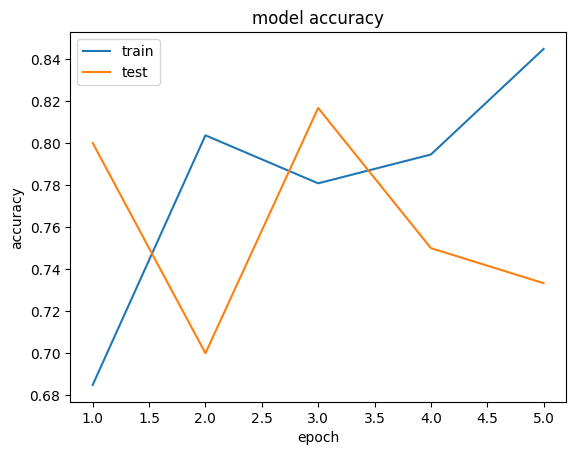

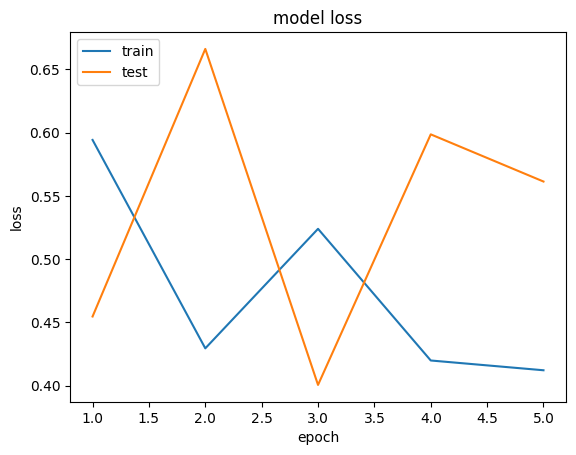

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# NOTE: ONLY WORKS FOR MULTIPLE EPOCHS

# PLOT ACCURACY
plt.plot(range(1, EPOCHS + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS + 1, 1),history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS + 1),history.history['loss'])
plt.plot(range(1, EPOCHS + 1),history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()